## Analysis of the Slide-seq V2 dataset only

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import umap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap

import INSPIRE

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
data_dir = "data/SlideseqV2_mouse_hippocampus"
adata_slideseqv2 = sc.read_h5ad(data_dir+"/adata_slideseqv2_Puck_200115_08.h5ad")
adata_slideseqv2.var_names_make_unique()
adata_slideseqv2

data_dir = "data/MERFISH_mouse_hippocampus"
adata_merfish = sc.read_h5ad(data_dir + "/raw_counts_mouse1_coronal.h5ad")
adata_merfish = adata_merfish[adata_merfish.obs["slice_id"] == "co1_slice37", :]
adata_merfish.var_names_make_unique()
adata_merfish.obsm["spatial"] = np.array(adata_merfish.obs[["center_x","center_y"]].values)
adata_merfish.obsm["spatial"][:,1] = -adata_merfish.obsm["spatial"][:,1]

Get shared genes among all datasets...
Find 1077 shared genes among datasets.
Finding highly variable genes...
shape of adata 0 before quality control:  (44959, 1077)
shape of adata 0 after quality control:  (44950, 1077)
shape of adata 1 before quality control:  (53208, 1077)
shape of adata 1 after quality control:  (29866, 1019)
Find 936 shared highly variable genes among datasets.
Concatenate datasets as a full anndata for better visualization...


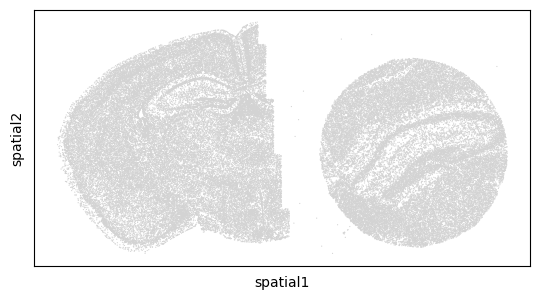

Store counts and library sizes for Poisson modeling...
Normalize data...


In [3]:
adata_st_list = [adata_merfish, adata_slideseqv2]
adata_st_list, adata_full = INSPIRE.utils.preprocess(adata_st_list=adata_st_list,
                                                     num_hvgs=1000,
                                                     min_genes_qc=6,
                                                     min_cells_qc=6,
                                                     spot_size=30,
                                                     limit_num_genes=True)

In [4]:
data_dir = "data/SlideseqV2_mouse_hippocampus"
adata_slideseqv2 = sc.read_h5ad(data_dir+"/adata_slideseqv2_Puck_200115_08.h5ad")
adata_slideseqv2.var_names_make_unique()
adata_slideseqv2.obs.index = adata_slideseqv2.obs.index + "-1"
adata_slideseqv2 = adata_slideseqv2[adata_st_list[1].obs.index, :]

### Follow Scanpy pipeline to perform spatial region identification

In [5]:
adata = adata_slideseqv2

hvg_num = 1000
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=hvg_num)
hvgs = adata.var[adata.var.highly_variable == True].sort_values(by="highly_variable_rank").index

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, hvgs]
sc.pp.scale(adata, max_value=10)

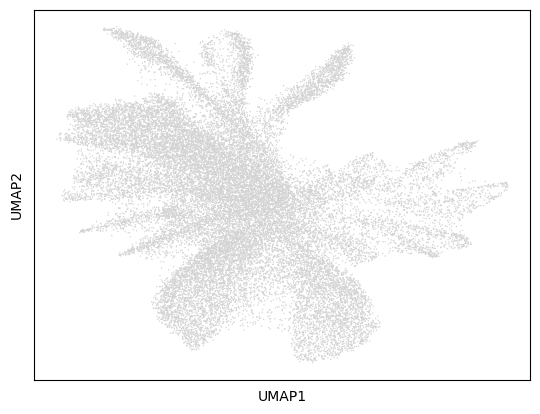

In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

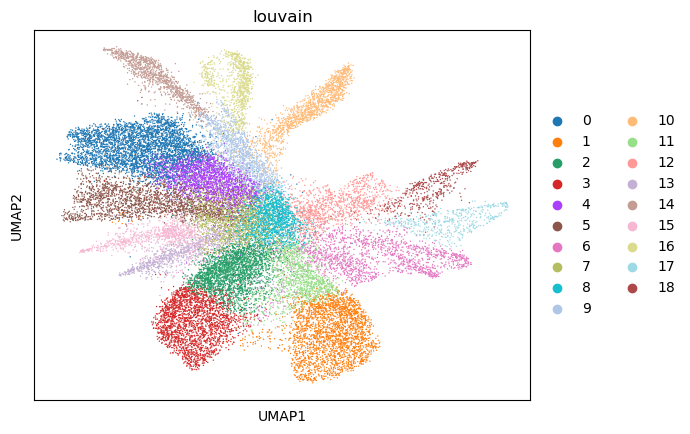

In [7]:
sc.tl.louvain(adata, resolution=1.5)
sc.pl.umap(adata, color=["louvain"])

In [8]:
rgb_10 = [i for i in get_cmap('Set3').colors]
rgb_20 = [i for i in get_cmap('tab20').colors]
rgb_20b = [i for i in get_cmap('tab20b').colors]
rgb_dark2 = [i for i in get_cmap('Dark2').colors]
rgb_pst1 = [i for i in get_cmap('Pastel1').colors]
rgb_acc = [i for i in get_cmap('Accent').colors]
rgb2hex_10 = [mpl.colors.rgb2hex(color) for color in rgb_10]
rgb2hex_20 = [mpl.colors.rgb2hex(color) for color in rgb_20]
rgb2hex_20b = [mpl.colors.rgb2hex(color) for color in rgb_20b]
rgb2hex_20b_new = [rgb2hex_20b[i] for i in [0, 3, 4, 7, 8, 11, 12, 15, 16, 19]]
rgb2hex_dark2 = [mpl.colors.rgb2hex(color) for color in rgb_dark2]
rgb2hex_pst1 = [mpl.colors.rgb2hex(color) for color in rgb_pst1]
rgb2hex_acc = [mpl.colors.rgb2hex(color) for color in rgb_acc]
rgb2hex = rgb2hex_20 + rgb2hex_20b_new + rgb2hex_dark2 + rgb2hex_pst1 + rgb2hex_acc
colors = rgb2hex
adata.obs["louvain_color"] = ""
for i in range(len(set(adata.obs["louvain"].values.astype(str)))):
    adata.obs["louvain_color"][adata.obs["louvain"].values.astype(str) == str(i)] = colors[i]

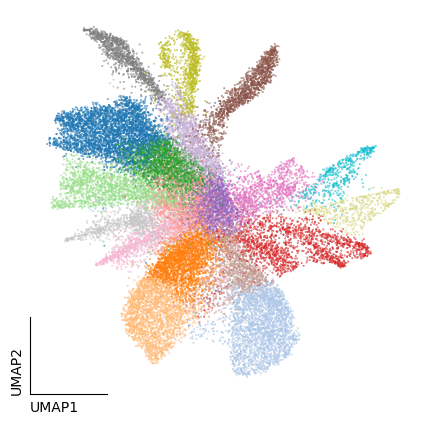

In [9]:
size = 0.1
umap = adata.obsm["X_umap"]
n_cells = umap.shape[0]
np.random.seed(1234)
order = np.arange(n_cells)
np.random.shuffle(order)

f = plt.figure(figsize=(5,5))

ax3 = f.add_subplot(1,1,1)
scatter2 = ax3.scatter(umap[order, 0], umap[order, 1], s=size, c=adata.obs["louvain_color"][order], rasterized=True, marker='o')
ax3.tick_params(axis='both',bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False, grid_alpha=0)
ax3.spines['left'].set_bounds(ax3.get_ylim()[0], ax3.get_ylim()[0]+(ax3.get_ylim()[1]-ax3.get_ylim()[0])*0.2)
ax3.spines['bottom'].set_bounds(ax3.get_xlim()[0], ax3.get_xlim()[0]+(ax3.get_xlim()[1]-ax3.get_xlim()[0])*0.2)
ax3.spines['right'].set_bounds(0, 0)
ax3.spines['top'].set_bounds(0, 0)
ax3.set_xlabel('UMAP1', loc='left', fontsize=10)
ax3.set_ylabel('UMAP2', loc='bottom', fontsize=10)
f.subplots_adjust(hspace=0.02, wspace=0.1)

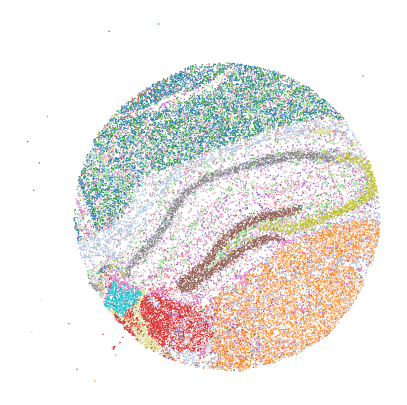

In [10]:
size = 1.
n_louvain = len(set(adata.obs["louvain"]))
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
ax.scatter(adata.obsm["spatial"][:, 0], 
           -adata.obsm["spatial"][:, 1], 
           s=size, facecolors=adata.obs["louvain_color"], edgecolors='none', rasterized=True)
ax.set_axis_off()
f.subplots_adjust(hspace=0.02, wspace=0.1)
plt.show()